In [1]:
from warnings import warn
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import scipy
from IPython.display import HTML
from matplotlib import animation
from scipy import signal
from scipy.integrate import simps
from scipy.interpolate import interp1d
from scipy.signal.windows import gaussian


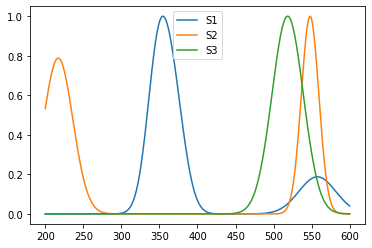

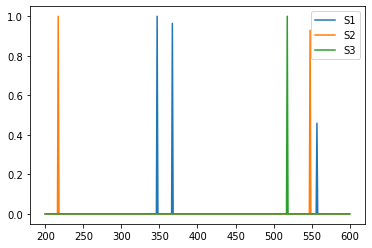

In [2]:
MIN_WL=200
MAX_WL=600
WL_INC=1
#np.random.seed(10)


def gauss_filter(sig, w,inc, x=None,renorm=True,target_area=None):
    sig_w  = w / (2 * np.sqrt(2 * np.log(2)))
    win = gaussian(int(1/inc * sig_w * 8), 1/inc * sig_w)
    conv=np.zeros_like(sig)
    if len(sig.shape) == 1:
        conv = signal.convolve(sig, win, mode='same')
    else:
        for i in range(sig.shape[0]):
            conv[i] = signal.convolve(sig[i], win, mode='same')
    if renorm:
        if target_area is not None:
            a0 = target_area
        else:
            a0=simps(y=sig,x=x)

        a=simps(y=conv,x=x)
        if a != 0:
            conv = conv*(a0/a)
    return conv

class ChromaSubstance():
    def __init__(self,name,spec_data=None):
        self.name = name
        if spec_data is None:
            spec_data = (MIN_WL+np.random.random(np.random.randint(1,4)*3)*(MAX_WL-MIN_WL)).reshape(-1,3)
            spec_data[:,1] = spec_data[:,1]/spec_data[:,1].sum()
            spec_data[:,2] = spec_data[:,2]/10

        self.spec_range=np.arange(MIN_WL,MAX_WL+WL_INC,WL_INC)
        self.spec_data=[]
        signalsconv = np.zeros_like(self.spec_range,dtype=float)
        for peak in spec_data:
            psignal = np.zeros_like(self.spec_range,dtype=float)
            t_index=np.argmin(np.abs(self.spec_range - peak[0]))
            psignal[t_index] = peak[1]
            self.spec_data.append(psignal)
            conv = gauss_filter(psignal,w=peak[2],inc=WL_INC,target_area=peak[1])
            signalsconv += conv

        self.spectrum = signalsconv/signalsconv.max()
        self.spec_data=np.array(self.spec_data)
        self.spec_data=self.spec_data/self.spec_data.max()

        self.columns_rs={}

    def __str__(self):
        return self.name
fronter = ChromaSubstance("Fronter")
cs1 = ChromaSubstance("S1")
cs2 = ChromaSubstance("S2")
cs3 = ChromaSubstance("S3")

plt.plot(cs1.spec_range,cs1.spectrum,label=cs1)
plt.plot(cs2.spec_range,cs2.spectrum,label=cs2)
plt.plot(cs3.spec_range,cs3.spectrum,label=cs3)
plt.legend()
plt.show()
plt.close()
plt.plot(cs1.spec_range,cs1.spec_data.sum(axis=0),label=cs1)
plt.plot(cs2.spec_range,cs2.spec_data.sum(axis=0),label=cs2)
plt.plot(cs3.spec_range,cs3.spec_data.sum(axis=0),label=cs3)
plt.legend()
plt.show()
plt.close()

In [ ]:
class GraphMixin():
    connection_type="edge"
    connection_weight=1
    node_type="node"
    def __init__(self,nodes=[],connections=[],labels=None,*args,**kwargs):
        super().__init__(*args,**kwargs)
        self._graph = nx.Graph()
        for i,n in enumerate(nodes):
            self._graph.add_node(n,type=self.node_type,label=n if labels is None else labels[i])

        for connection in connections:
            self._graph.add_edge(nodes[connection[0]],nodes[connection[1]],type=self.connection_type,weight=self.connection_weight)

    def add_connection(self,node1,node2):
        g,d = self.get_graph(level=-1)
        print(node1,node1,list(g.nodes))
        assert node1 in g.nodes or node1 in d['graph_rep']
        assert node2 in g.nodes or node2 in d['graph_rep']

        self._graph.add_edge(node1,node2,type=self.connection_type,weight=self.connection_weight)

    def __getitem__(self, item):
        return list(self._graph.nodes)[item]

    def get_graph(self,level=-1):
        g = nx.Graph()
        graph_rep = {}
        base_node = None
        for node in self._graph.nodes(data=True):
            if isinstance(node[0],GraphMixin) and level !=0:
                sg,data = node[0].get_graph(level=level-1)
                graph_rep[node[0]]=data
                g.add_nodes_from(sg.nodes(data=True))
                g.add_edges_from(sg.edges(data=True))
                if base_node is None:
                    base_node = data["base_node"]
            else:
                g.add_nodes_from([node])
                if base_node is None:
                    base_node = node[0]

        for edge in self._graph.edges(data=True):
            es = edge[0]
            et = edge[1]

            if es in graph_rep:
                es = graph_rep[es]["base_node"]
            if et in graph_rep:
                et = graph_rep[et]["base_node"]
            g.add_edges_from([(es,et,edge[2])])

        return g,{"base_node":base_node,"graph_rep":graph_rep}

g1=GraphMixin(nodes=[0,1,2,3,4],connections=[(0,1),(0,2),(0,3),(0,4)])
g2=GraphMixin(nodes=[5,6,7,8,9],connections=[(0,1),(0,2),(0,3),(0,4)])
g3=GraphMixin(nodes=[g1,g2],connections=[(0,1)])

g,_ = g1.get_graph()
nx.draw_spring(g,with_labels=True)
plt.show()
plt.close()

g,_ = g3.get_graph()
nx.draw_spring(g,with_labels=True)
plt.show()
plt.close()
g,_ = g3.get_graph(level=0)
nx.draw_spring(g,with_labels=True)
plt.show()
plt.close()

g4=GraphMixin(nodes=[g1,g3])
g4.add_connection(g2[2],g3)
g,_ = g4.get_graph()
nx.draw_spring(g,with_labels=True)
plt.show()
plt.close()

g,_ = g4.get_graph(level=0)
nx.draw_spring(g,with_labels=True)
plt.show()
plt.close()

In [ ]:
class FlowSetup(GraphMixin):
    connection_type="flow_element_connection"
    connection_weight=0.5
    node_type="flow_element"

    def connect_ports(self,p1,p2):
        if isinstance(p1,FlowElement):
            p1=(p1,0)
        if isinstance(p2,FlowElement):
            p2=(p2,0)

        self.add_connection(p1[0].get_port(p1[1]),p2[0].get_port(p2[1]))

class FlowElement(GraphMixin):
    _ele_count=0
    prefix="flow_ele"
    node_type="port"
    def __init__(self, ports=0,internal_connections=[], potential=None, *args, **kwargs):
        self._number=self._ele_count
        self._port_names = ["port_{}_{}".format(i,self._number) for i in range(ports)]

        FlowElement._ele_count+=1
        #super().__init__(node_names=["port_{}_{}".format(i,self._number) for i in range(ports)],connections=internal_connections,*args, **kwargs)
        super().__init__(
            nodes=["{}_{}".format(self.prefix,self._number) ]+self._port_names,
            connections=[(0,i+1) for i in range(ports)],
            *args, **kwargs)

    def get_port(self,i):
        return self._port_names[i]

    @property
    def port(self):
        if len(self._port_names) == 1:
            return self.get_port(0)
        else:
            return self.get_port

class FlowSource(FlowElement):
    prefix="source"
    def __init__(self,potential=100):
            super().__init__(ports=1,potential=potential)

class FlowDrain(FlowElement):
    prefix="drain"
    def __init__(self,potential=0):
            super().__init__(ports=1,potential=potential)


class Column(FlowElement):
    def __init__(self):
        super().__init__(ports=2,internal_connections=[(0,1)],potential=None)

class Valve(FlowElement):
    def __init__(self,states,ports=None):
        if ports is None:
            ports=-1
            for state in states:
                for pair in state:
                    ports=max(ports,pair[0],pair[1])
            ports+=1
        super().__init__(ports=ports,internal_connections=states[0],potential=None)


class SixPortValve(Valve):
    def __init__(self):
        super().__init__(states=[[(0,1),(2,3),(4,5)]],)

fs=FlowSetup()

pump=FlowSource()
waste=FlowDrain()

v1=SixPortValve()

c1=Column()
c2=Column()

fs=FlowSetup(nodes=[pump,v1,waste],connections=[(0,1),(1,2)])
fs.connect_ports(pump,(v1,0))

g,_ = fs.get_graph(level=-1)
#nx.draw_spring(g,with_labels=True)


edge_color_map={'port_relation':'b',
                'external_port_connection':'r',
                'internal_connection':'g',
                }
node_color_map={'port':'g',
                'flow_element':'b',
                }
nx.draw(g,
        pos=nx.spring_layout(
            g,
        ),
        with_labels=True,
        labels={node[0]:node[1].get('label',node[0]) for node in g.nodes(data=True)},
        node_color=[ node_color_map.get(node[1]['type'],"k")  for node in g.nodes(data=True)]
        ,
        edge_color=[ edge_color_map.get(edge[2]['type'],"k")  for edge in g.edges(data=True)]
        )

In [103]:
class FlowSetup(GraphMixin):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self._flow_elements = []


    def add_elements(self,*args):
        for e in args:
            self.add_element(e)

    def add_element(self,flow_element):
        self._flow_elements.append(flow_element)
        self._graph.add_nodes_from(flow_element.graph.nodes(data=True))
        self._graph.add_edges_from(flow_element.graph.edges(data=True))

    def get_connection_dict(self,forward=True):
        if forward:
            return dict(self._connections)
        else:
            return dict((v,k) for k,v in self.get_connection_dict(forward=True).items())

    @property
    def connections(self):
        return self.get_connection_dict(forward=True)

    def disconnect(self,port,other=None):
        if other:
            if (port,other) in self._connections:
                self._connections.remove((port,other))
                self._graph.remove_edge(port,other)
            return
        fc=self.get_connection_dict(forward=True)
        if port in fc:
            self.disconnect(port,other=fc[port])
        bc=self.get_connection_dict(forward=False)
        if port in bc:
            self.disconnect(fc[port],other=port)

    def connect(self,portA,portB,reconnect=False):
        fc=self.get_connection_dict(forward=True)
        if portA in fc:
            if not reconnect:
                raise ConnectionError("portA '{}' already connected with '{}'".format(portA,fc[portA]))
            self.disconnect(portA)
        if portB in fc:
            if not reconnect:
                raise ConnectionError("portB '{}' already connected with '{}'".format(portB,fc[portB]))
            self.disconnect(portB)

        bc=self.get_connection_dict(forward=False)
        if portA in bc:
            if not reconnect:
                raise ConnectionError("portA '{}' already connected with '{}'".format(portA,bc[portA]))
            self.disconnect(portA)
        if portB in bc:
            if not reconnect:
                raise ConnectionError("portB '{}' already connected with '{}'".format(portB,bc[portB]))
            self.disconnect(portB)

        self._connections.append((portA,portB))
        self._graph.add_edge(portA,portB,type="external_port_connection",weight=0.1)

    @property
    def graph(self):
        return self._graph

    @property
    def flow_graph(self):
        all_ports={}
        g=nx.DiGraph()
        for a,b in self.connections.items():
            g.add_edge(a,b)

        for e in self._flow_elements:
            pass

        return g



    #@property
    #def get_potentials(self):

class FlowElement(GraphMixin):
    _ele_count=0
    connection_type="internal_connection"
    connection_weight=0.01

    def __init__(self, ports=2, internal_connections=[], potential=None, *args, **kwargs):
        self._number=self._ele_count
        FlowElement._ele_count+=1


        super().__init__(
            node_names=["port_{}_{}".format(i,self._number) for i in range(ports)],
            connections=internal_connections,
            *args, **kwargs)


        self._ele_name="element_{}".format(self._number)
        self._graph.add_node(self._ele_name,type="flow_element",label="ele")
        self._port_names=[]

        if isinstance(potential,(tuple,list)):
            assert len(potential) == ports
        else:
            potential = [potential]*ports

        self._potential=potential

        for i in range(ports):
            pn="port_{}_{}".format(i,self._number)
            self._port_names.append(pn)
            self._graph.add_node(pn,type="port",label=i)
            self._graph.add_edge(self._ele_name,pn,type="port_relation",weight=5)

        for ic in self._internal_connections:
            self._graph.add_edge(self._port_names[ic[0]],self._port_names[ic[1]],type="internal_connection",weight=0.01)

    def get_port(self,i):
        return self._port_names[i]

    @property
    def port(self):
        if len(self._port_names) == 1:
            return self.get_port(0)
        else:
            return self.get_port

    @property
    def graph(self):
        return self._graph



class FlowSource(FlowElement):
    def __init__(self,potential=100):
            super().__init__(ports=1,potential=potential)

class FlowDrain(FlowElement):
    def __init__(self,potential=0):
            super().__init__(ports=1,potential=potential)

class Column(FlowElement):
    def __init__(self):
        super().__init__(ports=2,internal_connections=[(0,1)],potential=None)

class Valve(FlowElement):
    def __init__(self,states,ports=None):
        if ports is None:
            ports=-1
            for state in states:
                for pair in state:
                    ports=max(ports,pair[0],pair[1])
            ports+=1
        super().__init__(ports=ports,internal_connections=states[0],potential=None)


class SixPortValve(Valve):
    def __init__(self):
        super().__init__(states=[[(0,1),(2,3),(4,5)]],)

fs=FlowSetup()

pump=FlowSource()
waste=FlowDrain()

v1=SixPortValve()

c1=Column()
c2=Column()

fs.add_elements(pump,waste,c1,c2,v1)


fs.connect(pump.port,c1.port(0))
fs.connect(c1.port(1),c2.port(0))
fs.connect(c2.port(1),waste.port)

edge_color_map={'port_relation':'b',
                'external_port_connection':'r',
                'internal_connection':'g',
                }
node_color_map={'port':'g',
                'flow_element':'b',
                }
nx.draw(fs.graph,
        pos=nx.spring_layout(
            fs.graph,
        ),
        with_labels=True,
        labels={node[0]:node[1].get('label',node[0]) for node in fs.graph.nodes(data=True)},
        node_color=[ node_color_map.get(node[1]['type'],"k")  for node in fs.graph.nodes(data=True)]
        ,
        edge_color=[ edge_color_map.get(edge[2]['type'],"k")  for edge in fs.graph.edges(data=True)]
        )

TypeError: object.__init__() takes exactly one argument (the instance to initialize)

In [ ]:
fm = fs.flow_graph
nx.draw(fs.flow_graph,
        pos=nx.spring_layout(
            fs.flow_graph,
        ),
        with_labels=True,
        #labels={node[0]:node[1].get('label',node[0]) for node in fs.graph.nodes(data=True)},
        #node_color=[ node_color_map.get(node[1]['type'],"k")  for node in fs.graph.nodes(data=True)]
        #,
        #edge_color=[ edge_color_map.get(edge[2]['type'],"k")  for edge in fs.graph.edges(data=True)]
        )